<a href="https://colab.research.google.com/github/Ploux/constructionCI/blob/master/mco_mnist_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Digit Classification model on a Google TPU Using Keras and TensorFlow
<table><tr><td><img valign="middle" src="https://raw.githubusercontent.com/marcacohen/mnist-draw/master/mnist-draw.gif" width="300" alt="Keras+Tensorflow+Cloud TPU"></td></tr></table>


**This lab is derived from Martin Gorner's excellent, comprehensive, and highly recommended [Learn TensorFlow and deep learning, without a Ph.D.](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd) series.**

This lab trains and evaluates a handwritten digit classification model using the MNIST dataset. It uses a Google Tensor Processing Unit (TPU) to speed up
training and includes an interactive component that lets you test your model by drawing your own digits right inside this notebook.
This notebook is provided for educational purposes only.

Here's what we'll do in this lab:

<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>&nbsp;&nbsp; Train on TPU</h3>

Select a TPU backend (Runtime > Change runtime type)

<h3><a href="https://www.tensorflow.org/js">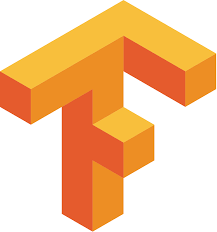</a>&nbsp;&nbsp; Test our model interactively with TensorFlow.js</h3>

Export our model for use in JavaScript and run an interactive web app to test the model interactively, with hand drawn digits.

<h3><a href="https://cloud.google.com/ml-engine/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/mlengine-hexagon.png" width="50"></a>  &nbsp;&nbsp;Deploy to AI Platform</h3>
At the bottom of this notebook you can deploy your trained model to AI Platform for a serverless, autoscaled, REST API experience. You will need a Google Cloud project and a GCS (Google Cloud Storage) bucket for this last part.

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage.

## Start with no accelerator

In the Colab menu bar, select Runtime -> Change Runtime, set Runtime type to 'Python3', Hardware accelerator to 'None', and click SAVE.

![alt text](https://raw.githubusercontent.com/marcacohen/mnist-draw/master/img/cpu.png)


## Imports (*)
These are Python modules we'll need throughout this lab, including TensorFlow, which is Google's open source framework for graph computation. The latter dependency is so critical to this lab that we also display the version of TensorFlow we're importing into this notebook.

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import IPython.display as display
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.18.0


In [2]:
%%shell
TF_USE_LEGACY_KERAS=1

## Parameters (*)

These are global variables that allow to specify invariant constants that are useful throughout this lab. In particular, we'll specify things like the batch size and number of epochs (iterations through our training data), as well as URLs to our training and validation data. If you've never seen URLs of the form gs://, those are paths to objects in [Google Cloud Storage](http://cloud.google.com/storage).

In [4]:
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.
BATCH_SIZE = 64 # Gobal batch size.
EPOCHS = 10
LEARNING_RATE = 0.01
TF_USE_LEGACY_KERAS=1

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

## Utility Functions (*)
This section contains two collections of Python utility functions, which are required for proper execution but not critical for understanding the main ideas or the flow of this notebook. As such, both cells need to be executed but the contents are hidden. If you really want to understand every step along the way, feel free to unhide those cells and have a look at these utility functions. One of the nice things about working in Python is the code tends to be quite readable.

In [5]:
#@title Visualization Utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.apply(tf.data.experimental.unbatch()).batch(N)

  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break

  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])

  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)

  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)

# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, steps_per_epoch, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = steps_per_epoch

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()

    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)

    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

  def on_train_end(self, logs={}):
    display.clear_output(wait=True)

    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)

    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [6]:
#@title Data Processing Utilities [RUN ME]
"""
This cell contains helper functions used for data processing only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label

def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image

def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset

def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset

def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

In [7]:
#@title Training Utilities [RUN ME]
"""
This cell contains helper functions for compiling and training models.
"""

def set_strategy(accelerator):
  strategy = None
  if accelerator == 'tpu':
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('TPU initialized: ', tpu.cluster_spec().as_dict()['worker'])
  elif accelerator == 'gpu':
    gpus = tf.config.experimental.list_logical_devices("GPU")
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
  else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
  print("Number of accelerators: ", strategy.num_replicas_in_sync)

  batch_size = BATCH_SIZE*strategy.num_replicas_in_sync
  LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
  # Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
  # 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.
  # set up learning rate decay
  lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)
  training_dataset = get_training_dataset(training_images_file, training_labels_file, batch_size)
  validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)
  return (strategy, batch_size, lr_decay, training_dataset, validation_dataset)

def compile(model):
  model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return

def train(model, strategy, epochs=EPOCHS, batch_size=BATCH_SIZE):
  steps_per_epoch = 60000 // batch_size  # 60,000 items in this dataset
  print("steps_per_epoch=", steps_per_epoch)

  plot_training = PlotTraining(steps_per_epoch, sample_rate=1, zoom=1)
  # Little wrinkle: in the present version of Tensorfow (1.14), switching a TPU
  # between training and evaluation is slow (approx. 10 sec). For small models,
  # it is recommeneded to run a single eval at the end.
  history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch,
                      epochs=EPOCHS, callbacks=[lr_decay, plot_training])

  final_stats = model.evaluate(validation_dataset, steps=1)
  print("Validation accuracy: ", final_stats[1])

## Let's have a look at the data

Here we display 24 digits and their correponding labels, as a kind of quick sanity check of our training and validation data.

In [9]:
(strategy, batch_size, lr_decay, training_dataset, validation_dataset) = set_strategy('cpu')
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

Running on CPU
Number of accelerators:  1


PermissionDeniedError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error executing an HTTP request: HTTP response code 401 with body '{
  "error": {
    "code": 401,
    "message": "Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist).",
    "errors": [
      {
        "message": "Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist).",
        "domain": "global",
        "reason": "required",
        '
	 when reading metadata of gs://mnist-public/t10k-images-idx3-ubyte [Op:IteratorGetNext] name: 

## First Try - A Naive Yet Functional Network

In this first attempt at building a neural network to recognize handwritten digits, we're using about the simplest network imaginable. It's only two layers, one which has a node for every input pixel and then a dense layer (meaning fully connected to all the first layer nodes), which uses the softmax activation function to generate an output probility for each of ten given classes, representing the digits zero to nine.

Running on CPU
Number of accelerators:  1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

steps_per_epoch= 937

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/10


PermissionDeniedError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-10-2553795323.py", line 12, in <cell line: 0>

  File "/tmp/ipython-input-7-3873786576.py", line 48, in train

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Error executing an HTTP request: HTTP response code 401 with body '{
  "error": {
    "code": 401,
    "message": "Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist).",
    "errors": [
      {
        "message": "Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object. Permission 'storage.objects.get' denied on resource (or it may not exist).",
        "domain": "global",
        "reason": "required",
        '
	 when reading metadata of gs://mnist-public/train-images-idx3-ubyte
	 [[{{node IteratorGetNext}}]] [Op:__inference_multi_step_on_iterator_1092]

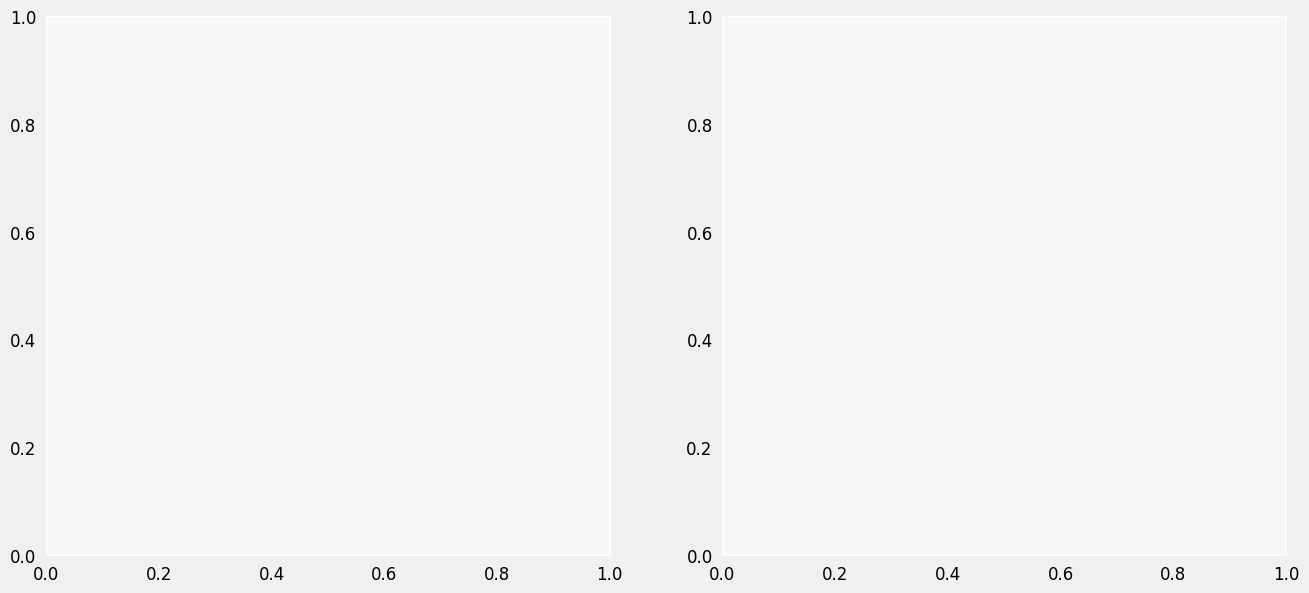

In [10]:
(strategy, batch_size, lr_decay, training_dataset, validation_dataset) = set_strategy('cpu')

with strategy.scope():
  model = tf.keras.Sequential(
  [
    tf.keras.layers.Input(shape=(28*28,)),
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  compile(model)

model.summary()
train(model, strategy)

# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## A (much) better model: 3 convolutional layers, 2 dense layers (*)
In this step we're fast forwarding to advance our model from a very simple naive approach to a much more sophisticated model, featuring five layers and including some advanced techniques, such as the rectfied linear unit activation function, Batch Normalization, and Dropout. Probably the most impactful advance here is the use the of convolution layers, which scan the input in a grid of related pixels, vs. treating each pixel in isolation. This improves the network's efficiency because it learns in a way that encompasses more context, just as our brains do when processing visual input.

One thing to notice about specifying neural networks in Keras is the "Lego-like" way we can assemble relatively complex networks by snapping layers together in a sequential fashion.

If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample).

In [11]:
def make_model():
 return tf.keras.Sequential(
  [
    tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),

    tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
    tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
    tf.keras.layers.Activation('relu'), # activation after batch norm

    tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
    tf.keras.layers.BatchNormalization(scale=False, center=True),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
    tf.keras.layers.BatchNormalization(scale=False, center=True),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, use_bias=False),
    tf.keras.layers.BatchNormalization(scale=False, center=True),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

    tf.keras.layers.Dense(10, activation='softmax')
  ])

## Train and validate model on CPU
So far we've only specified data structures defining out network but we haven't done anything with it yet! In essence, we've given Keras a blueprint for the network we want to build, train, and use to make predictions. In this step we compile the network, giving Keras three critical inputs:

1. the optimizer, which dictates how Keras should find its way toward the best solution
1. the loss function, which tells Keras how to assess the quality of our model's results at each iteration through the training data
1 a set of metrics, not strictly required by Keras, but helpful for us to track how our model progresses toward its goal

The call to model.summary() provides a terse textual representation of the model structure (we saw this output already with our naive model).

Lastly, and perhaps most interestingly, the model.fit() method actually kicks of the training process. We pass that method everything Keras needs to train our model:  training data and labels,  validation data and labels, number of iterations (epochs), number of steps per epoch, and a list of callback functions, which Keras should invoke at the end of every epoch. The callback functions are used to update our learning rate and graph the training progress.

In [ ]:
(strategy, batch_size, lr_decay, training_dataset, validation_dataset) = set_strategy('cpu')

with strategy.scope():
  model = make_model()
  compile(model)
model.summary()
train(model, strategy)

# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

##STOP!!! THIS IS TAKING TOO LONG!!!
Stop the cell above and let's retry training this model on a GPU...

## Train and validate the model on GPU

In the Colab menu bar, select Runtime -> Change Runtime, set Runtime type to 'Python3', Hardware accelerator to 'GPU', and click SAVE.

![alt text](https://raw.githubusercontent.com/marcacohen/mnist-draw/master/img/gpu.png)

**This action resets the runtime so you now need to rerun all the cells above marked with "(*)" before proceeding.**

In [ ]:
(strategy, batch_size, lr_decay, training_dataset, validation_dataset) = set_strategy('gpu')

with strategy.scope():
  model = make_model()
  compile(model)
model.summary()
train(model, strategy, batch_size=batch_size)

# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Train and validate the model on TPU
Google provides special hardware called Tensor Processing Units, which are custom designed to perform the sort of tensor calculations that form the core of neural network training. As a result, using a TPU can vastly reduce your model's training time. Run this cell to restart training this model on a Google TPU and notice how much faster the process proceeds.

The code in this cell is nearly identical to the previous cell, which tells you that you can include a TPU in your workflow with mimimal impact to your model training code.

In the Colab menu bar, select Runtime -> Change Runtime, set Runtime type to 'Python3', Hardware accelerator to 'TPU', and click SAVE.

![alt text](https://raw.githubusercontent.com/marcacohen/mnist-draw/master/img/tpu.png)

**This action resets the runtime so you now need to rerun all the cells above marked with "(*)" before proceeding.**

Note that this is not the best  benchmark for TPUs (the TPU is probably at around 10% utilization when training this model) and it may not be much faster than using GPUs. But I'm using the MNIST model in this notebook because it's become a sort of "Hello World" example of Machine Learning in practice and it's helpful to use a simple model to show how easy it is to use TPUs in the Google Cloud.

In [ ]:
(strategy, batch_size, lr_decay, training_dataset, validation_dataset) = set_strategy('tpu')

with strategy.scope():
  model = make_model()
  compile(model)
model.summary()
train(model, strategy, batch_size=batch_size)

# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Save model and prep for use by TensorFlow.js
We now want to run an interactive test where we draw digits right in this notebook and see how our model does in classifying them. For maximum responsiveness and low delay, we'll export our model so that it can be run in a browser using TensorFlow.js, and we'll also install a web server that provides the resources needed to provide this interactive drawing widget.

In [ ]:
model.save('mnist.h5')

In [ ]:
%%shell
pip install tensorflowjs
rm -rf mnist-draw model
tensorflowjs_converter --input_format keras mnist.h5 model/
git clone https://github.com/marcacohen/mnist-draw.git
rm -rf mnist-draw/model
mv model mnist-draw
cd mnist-draw/
pip install -q -r requirements.txt
cd ..

## Run Some Interactive Tests
Run this cell to launch the interactive digit drawing canvas, which will enable you to draw digits with your mouse and classify them using the model you built in this notebook. See how well your model performs. Can you find any weaknesses?

In [ ]:
import http.server
import socketserver
import portpicker
import threading
import os
from google.colab import output
from IPython.display import Javascript

started = threading.Event()
port = portpicker.pick_unused_port()

# Start a background thread serving up the files.
def server_entry():
  os.chdir('/content/mnist-draw')
  with socketserver.TCPServer(("", port), http.server.SimpleHTTPRequestHandler) as httpd:
    started.set()
    httpd.serve_forever()

thread = threading.Thread(target=server_entry)
thread.start()
started.wait();

# Tell the JS side the port #
output.eval_js(f"window.mnistPort = {port}")

Javascript('''
  (async () => {
    if (!google.colab.kernel.accessAllowed) {
        // User needs to execute the notebook.
        return;
    }
    const url = await google.colab.kernel.proxyPort(window.mnistPort);
    const iframe = document.createElement('iframe');
    iframe.src = url;
    iframe.height = '500px';
    iframe.width = '100%';
    iframe.style.border = '0';
    document.body.appendChild(iframe);
  })()
''')

## Deploy the trained model to AI Platform

In this section we will push your trained model to production on AI Platform for a serverless, autoscaled, REST API experience.

You will need a GCS bucket and a GCP project for this.
Models deployed on ML Engine autoscale to zero if not used. There will be no ML Engine charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.

### Authentication for TPU Access

In [ ]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user() # Authenticates the backend and also the TPU using your credentials so that they can access your private GCS buckets

### Configuration

In [ ]:
PROJECT = "mco-keras" #@param {type:"string"}
BUCKET = "gs://mco-keras"  #@param {type:"string", default:"jddj"}
NEW_MODEL = True #@param {type:"boolean"}
MODEL_NAME = "mnist" #@param {type:"string"}
MODEL_VERSION = "v1" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

### Export the model for serving from AI Platform

In [ ]:
# Wrap the model so that we can add a serving function
class ExportModel(tf.keras.Model):
  def __init__(self, model):
    super().__init__(self)
    self.model = model

  # The serving function performig data pre- and post-processing.
  # Pre-processing:  images are received in uint8 format converted
  #                  to float32 before being sent to through the model.
  # Post-processing: the Keras model outputs digit probabilities. We want
  #                  the detected digits. An additional tf.argmax is needed.
  # @tf.function turns the code in this function into a Tensorflow graph that
  # can be exported. This way, the model itself, as well as its pre- and post-
  # processing steps are exported in the SavedModel and deployed in a single step.
  @tf.function(input_signature=[tf.TensorSpec([None, 28*28], dtype=tf.uint8)])
  def my_serve(self, images):
    images = tf.cast(images, tf.float32)/255   # pre-processing
    probabilities = self.model(images)          # prediction from model
    classes = tf.argmax(probabilities, axis=-1) # post-processing
    return {'digits': classes}

# Must copy the model from TPU to CPU to be able to compose them.
restored_model = make_model()
restored_model.set_weights(model.get_weights()) # this copies the weights from TPU, does nothing on GPU

# create the ExportModel and export it to the Tensorflow standard SavedModel format
serving_model = ExportModel(restored_model)
export_path = os.path.join(BUCKET, 'keras_export', str(time.time()))
tf.keras.backend.set_learning_phase(0) # inference only
tf.saved_model.save(serving_model, export_path, signatures={'serving_default': serving_model.my_serve})

print("Model exported to: ", export_path)

# Note: in Tensorflow 2.0, it will also be possible to
# export to the SavedModel format using model.save():
# serving_model.save(export_path, save_format='tf')

In [ ]:
# saved_model_cli: a useful tool for troubleshooting SavedModels (the tool is part of the Tensorflow installation)
!saved_model_cli show --dir {export_path}
!saved_model_cli show --dir {export_path} --tag_set serve
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default
# A note on naming:
# The "serve" tag set (i.e. serving functionality) is the only one exported by tf.saved_model.save
# All the other names are defined by the user in the fllowing lines of code:
#      def myserve(self, images):
#                        ******
#        return {'digits': classes}
#                 ******
#      tf.saved_model.save(..., signatures={'serving_default': serving_model.myserve})
#                                            ***************

### Deploy the model
This uses the command-line interface. You can do the same thing through the AI Platform UI at https://console.cloud.google.com/mlengine/models


In [ ]:
# Create the model
if NEW_MODEL:
  !gcloud ai-platform models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

In [ ]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
!gcloud ai-platform versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.14

### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ml-engine"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [ ]:
# prepare digits to send to online prediction endpoint
digits_float32 = np.concatenate((font_digits, validation_digits[:100-N])) # pixel values in [0.0, 1.0] float range
digits_uint8 = np.round(digits_float32*255).astype(np.uint8) # pixel values in [0, 255] int range
labels = np.concatenate((font_labels, validation_labels[:100-N]))
with open("digits.json", "w") as f:
  for digit in digits_uint8:
    # the format for AI Platform online predictions is: one JSON object per line
    data = json.dumps({"images": digit.tolist()})  # "images" because that was the name you gave this parametr in the serving funtion my_serve
    f.write(data+'\n')

In [ ]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
predictions = !gcloud ai-platform predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}
print(predictions)

predictions = np.stack([json.loads(p) for p in predictions[1:]]) # first elemet is the name of the output layer: drop it, parse the rest
display_top_unrecognized(digits_float32, predictions, labels, N, 100//N)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner<br>
Revised by: Marc Cohen (added text annotations, CPU vs. GPU vs. TPU training, interactive JS widget)


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
